In [5]:
import os
import glob
import pandas as pd
import concurrent.futures
import numpy as np
import matplotlib.pyplot as plt

In [38]:
def Flip_dataframes(df):
    """Process the dataframe: Remove negative x values, normalize x, and make negative values positive."""
    df = df[df['x'] >= 0].copy()
    first_x_value = df['x'].iloc[0]
    df['x'] = df['x'] - first_x_value
    df['x'] = df['x'].abs()
    
    return df

def Merging_BME(df_begin, df_middle, df_end, particle_folder, allow_gap=False):
    """Merging beginning, middle, and end. Allows inserting a gap if needed."""
    df_middle = df_middle.drop(index=0).reset_index(drop=True)
    last_x_value_df_begin = df_begin['x'].iloc[-1]
    df_middle['x'] = df_middle['x'] + last_x_value_df_begin

    # Check for jump between B and M
    if abs(df_middle['y'].iloc[0] - df_begin['y'].iloc[-1]) >= 0.05:
        print(f'WARNING: y-jump > 2 cm between B and M for {particle_folder}')
    else: 
        print(f'B-M OK for {particle_folder}')

    df_begin['t'] = df_begin['t'] - df_begin['t'].iloc[0]
    delta_t = df_begin['t'].iloc[1] - df_begin['t'].iloc[0]
    df_middle['t'] = df_middle['t'] + df_begin['t'].iloc[-1] + delta_t - df_middle['t'].iloc[0]

    merged_df_beginmiddle = pd.concat([df_begin, df_middle], ignore_index=True)

    df_end = df_end.drop(index=0).reset_index(drop=True)

    # -- CASE 3: allow a gap between M and E
    last_x_bm = merged_df_beginmiddle['x'].iloc[-1]
    last_t_bm = merged_df_beginmiddle['t'].iloc[-1]
    delta_t_2 = merged_df_beginmiddle['t'].iloc[1] - merged_df_beginmiddle['t'].iloc[0]

    gap_x = 0.1 if allow_gap else 0  # adjust based on your physical scale
    gap_t = 0.2 if allow_gap else 0

    df_end['x'] = df_end['x'] + last_x_bm + gap_x
    df_end['t'] = df_end['t'] + last_t_bm + delta_t_2 + gap_t - df_end['t'].iloc[0]

    # Check for jump between M and E
    if abs(df_end['y'].iloc[0] - merged_df_beginmiddle['y'].iloc[-1]) >= 0.05:
        print(f'WARNING: y-jump > 2 cm between M and E for {particle_folder}')
    else: 
        print(f'M-E OK for {particle_folder}')

    merged_df = pd.concat([merged_df_beginmiddle, df_end], ignore_index=True)
    return merged_df


In [31]:
def Merging_BE(df_begin, df_end, particle_folder):
    """Merging of the beginning and end parts when middle part is missing."""
    df_end = df_end.drop(index=0).reset_index(drop=True)
    
    df_begin['t'] = df_begin['t'] - df_begin['t'].iloc[0]
    delta_t = df_begin['t'].iloc[1] - df_begin['t'].iloc[0]
    
    df_end['x'] = df_end['x'] + df_begin['x'].iloc[-1]
    df_end['t'] = df_end['t'] + df_begin['t'].iloc[-1] + delta_t - df_end['t'].iloc[0]
    
    # Warn if y jump is big
    if abs(df_end['y'].iloc[0] - df_begin['y'].iloc[-1]) >= 0.05:
        print(f'WARNING: jump in y-values > 2 cm between beginning and end for {particle_folder}')
        print(f"The difference is {df_end['y'].iloc[0] - df_begin['y'].iloc[-1]} m")
    #else:
        #print(f'ALL GOOD: no jump in y values for {particle_folder} between beginning and end')
    
    merged_df = pd.concat([df_begin, df_end], ignore_index=True)
    return merged_df

In [48]:
# Replace with your actual function names

base_dir = '/Volumes/CAMI_2/TRAJECTORIES'
merged_data_dict = {}

for h_folder in os.listdir(base_dir):
    print(h_folder)
    h_path = os.path.join(base_dir, h_folder)
    if os.path.isdir(h_path):
        for run_folder in os.listdir(h_path):
            run_path = os.path.join(h_path, run_folder)
            if os.path.isdir(run_path) and run_folder.upper().startswith('RUN'):
                for particle_folder in os.listdir(run_path):
                    particle_path = os.path.join(run_path, particle_folder)
                    if os.path.isdir(particle_path) and particle_folder.upper().startswith('P'):

                        part_files = {'B': None, 'M': None, 'E': None}

                        for part in part_files:
                            pattern = os.path.join(particle_path, f'*_{part}.txt')
                            matches = glob.glob(pattern)
                            if matches:
                                part_files[part] = matches[0]

                        # Load and flip existing dataframes
                        dfs = {}
                        for part, path in part_files.items():
                            if path:
                                df = pd.read_csv(path, delimiter='\t', skiprows=1)
                                dfs[part] = Flip_dataframes(df)

                        # Merge based on what is available
                        merged_df = None
                        if 'B' in dfs and 'M' in dfs and 'E' in dfs:
                            merged_df = Merging_BME(dfs['B'], dfs['M'], dfs['E'], particle_folder, allow_gap=True)

                        elif 'B' in dfs and 'E' in dfs:
                            # Only beginning and end available — use alternate merging
                            merged_df = Merging_BE(dfs['B'], dfs['E'], particle_folder)

                        elif 'B' in dfs and 'M' in dfs:
                            # Only beginning and middle available — simulate end as last row
                            if not dfs['M'].empty:
                                empty_end = dfs['M'].iloc[[0]].copy()
                                dfs['M'] = dfs['M'].drop(index=0).reset_index(drop=True)
                                merged_df = Merging(dfs['B'], dfs['M'], empty_end, particle_folder)

                        # You can optionally handle or log cases with fewer files
                        else:
                            particle_files = glob.glob(os.path.join(particle_path, '*.txt'))
                            if particle_files:
                                first_filename = os.path.basename(particle_files[0])
                                particle_name = "_".join(first_filename.split('_')[:-1])  # e.g. H5_R2_P1
                            else:
                                particle_name = f"{h_folder}_{run_folder}_{particle_folder}"

                            print(f"Skipping {particle_name}: not enough trajectory parts available.")
                        if merged_df is not None:
                            # Try to find a clean particle name from any file
                            particle_files = glob.glob(os.path.join(particle_path, '*.txt'))
                            if particle_files:
                                first_filename = os.path.basename(particle_files[0])
                                particle_name = "_".join(first_filename.split('_')[:-1])  # e.g. H5_R2_P1
                            else:
                                particle_name = f"{h_folder}_{run_folder}_{particle_folder}"

                            merged_data_dict[particle_name] = merged_df
                            print(f"Stored trajectory: {particle_name}")

print(f"\nTotal merged datasets: {len(merged_data_dict)}")

H5
Stored trajectory: H5_R1_P2
Stored trajectory: H5_R1_P1
Stored trajectory: H5_R1_P3
Stored trajectory: H5_R1_P4
Skipping H5_R1_P5: not enough trajectory parts available.
Stored trajectory: H5_R1_P6
Stored trajectory: H5_R1_P7
Stored trajectory: H5_R1_P8
Skipping H5_R1_P9: not enough trajectory parts available.
Stored trajectory: H5_R1_P10
Stored trajectory: H5_R1_P11
Skipping H5_R1_P4: not enough trajectory parts available.
Stored trajectory: H5_R1_P14
Stored trajectory: H5_R1_P13
Stored trajectory: H5_R2_P1
Stored trajectory: H5_R2_P4
Stored trajectory: H5_R2_P3
Stored trajectory: H5_R2_P2
Stored trajectory: H5_R2_P13
Stored trajectory: H5_R2_P5
Stored trajectory: H5_R2_P6
The difference is 0.06315131859634882 m
Stored trajectory: H5_R2_P7
Stored trajectory: H5_R2_P8
Stored trajectory: H5_R2_P9
Stored trajectory: H5_R2_P10
Stored trajectory: H5_R2_P11
Stored trajectory: H5_R2_P12
Stored trajectory: H5_R2_P14
Skipping H5_R2_P15: not enough trajectory parts available.
Stored trajecto

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


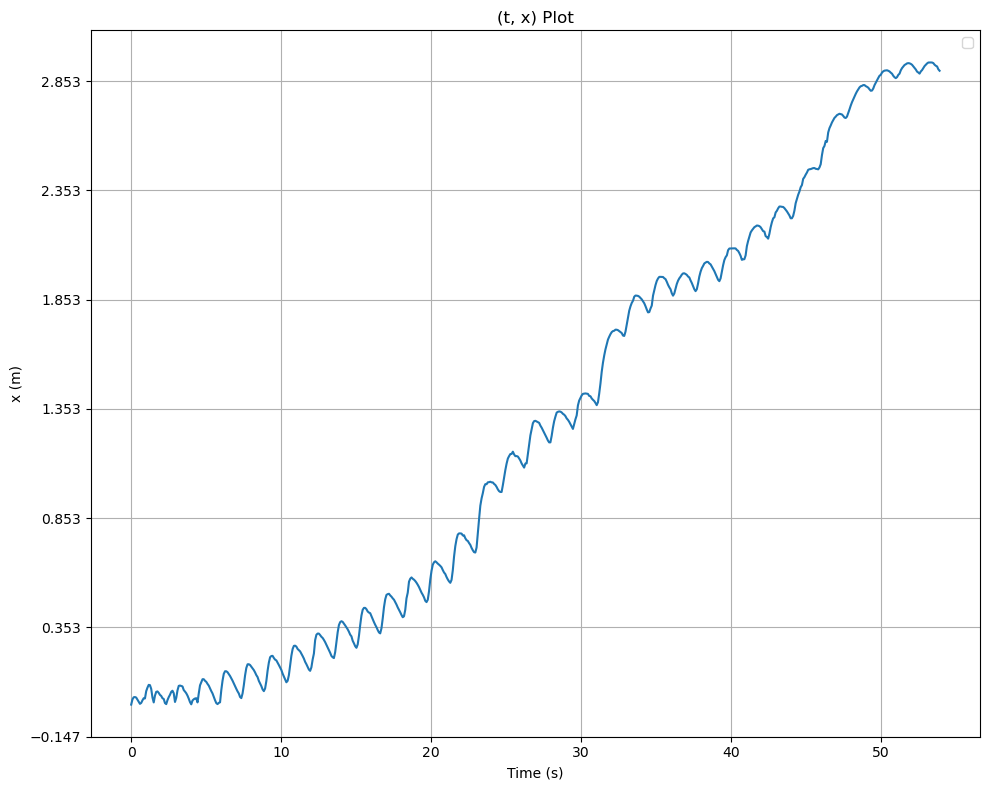

In [52]:

plt.figure(figsize=(10, 8))

# Subplot 1: (t, x) plot
df = merged_data_dict['H5_R1_P14']
plt.plot(df['t'], df['x'])
plt.xlabel('Time (s)')
plt.ylabel('x (m)')
plt.title('(t, x) Plot')

y_min, y_max = plt.ylim()  # Get the current y-axis limits
y_ticks = np.arange(y_min, y_max, 0.5)  # Adjust 0.1 to the desired step size
plt.yticks(y_ticks)


plt.legend()
plt.grid('both')

# Adjust layout and show the plots
plt.tight_layout()
plt.show()